In [48]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.linear_model as skl_lm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [49]:
# Import the dataset
df = pd.read_csv('https://raw.githubusercontent.com/vincenzorrei/EDU-Datasets/refs/heads/main/Default.csv')

# Set the index
df.set_index('Unnamed: 0', inplace=True)

# Rename the index
df.index.name = 'Index'

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
# We transform 'No' to 0 and 'Yes' to 1
df['default_enc'] = df.default.factorize()[0] # df['default'].factorize() returns a tuple, we only need the first element
df['student_enc'] = df.student.factorize()[0]
df[['default_enc','default','student_enc','student']].head()
df.head(3)


,default,student,balance,income,default_enc,student_enc
Index,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


In [50]:
# Get some information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      10000 non-null  object 
 1   student      10000 non-null  object 
 2   balance      10000 non-null  float64
 3   income       10000 non-null  float64
 4   default_enc  10000 non-null  int64  
 5   student_enc  10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


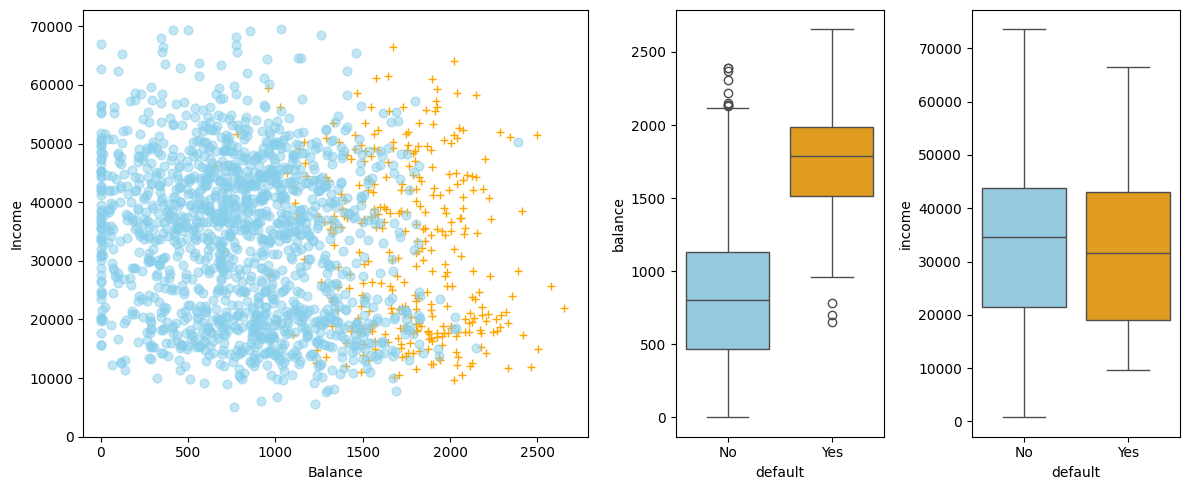

In [51]:
# Plot the data
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default_enc == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default_enc == 1]
df_ = pd.concat([df_no, df_yes])

ax1.scatter(x=df_[df_.default == 'Yes'].balance,
            y=df_[df_.default == 'Yes'].income,
            s=40, c='orange', marker='+',
            linewidths=1)

ax1.scatter(x=df_[df_.default == 'No'].balance,
            y=df_[df_.default == 'No'].income,
            alpha=.5, s=40, c='skyblue', marker='o',)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'skyblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, hue = 'default', palette=c_palette, legend=False)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, hue = 'default', palette=c_palette, legend=False)
gs.tight_layout(plt.gcf())


## Train and test split
We now work with balance as X and default as y

In [52]:
# Give the right shape to the data
x = df['balance'].values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df['default_enc']


In [53]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [54]:
# Confirm the shape of the data
print(f'Training set X: {X_train.shape}\nTraining set y: {X_train.shape}\n')
print(f'Test set X: {X_test.shape}\nTest set y: {X_test.shape}')


Training set X: (8000, 1)
Training set y: (8000, 1)

Test set X: (2000, 1)
Test set y: (2000, 1)


## Fit the model

In [55]:
# Fit the model
logistic = skl_lm.LogisticRegression()
logistic.fit(X_train, y_train)


LogisticRegression()

In [56]:
# Predict on train
x_proba = logistic.predict_proba([X_train[0]])
x_pred = logistic.predict([X_train[0]])

print('Class Order:', logistic.classes_)
print('Prob:', x_proba)
print('Model prediction:', x_pred)

Class Order: [0 1]
Prob: [[0.99780427 0.00219573]]
Model prediction: [0]


In [57]:
color_blue = "#1a559e"
color_pink = "#e71d71"

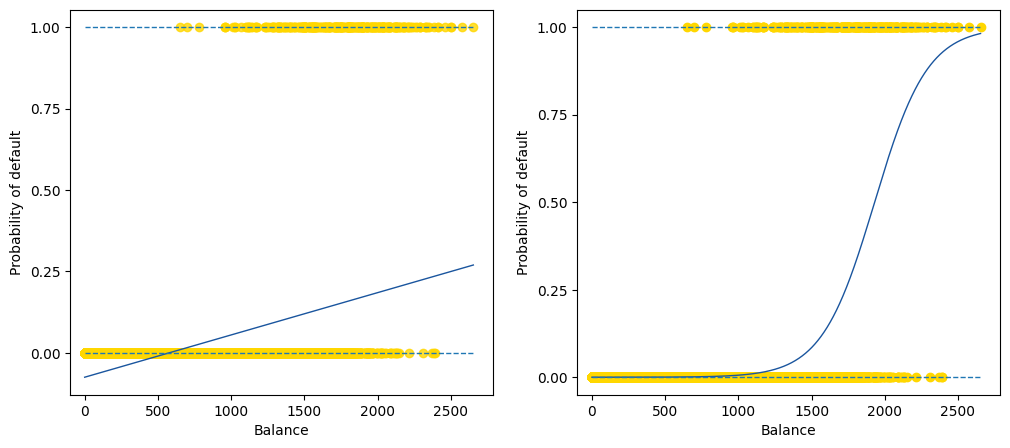

In [58]:
# Compare linear regression and logistic regression
X_space = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
prob = logistic.predict_proba(X_space)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(x=df.balance, y=df.default_enc, order=1, ci=None,
            scatter_kws={'color':'gold'},
            line_kws={'color':color_blue, 'lw':1}, ax=ax1)
# Right plot
ax2.scatter(x, y, color='gold')
ax2.plot(X_space, prob[:,1], color=color_blue, lw=1)

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [59]:
# Example of a new balance value
new_balance_obs = 2000

# Calculate the probability of default
prob_new_obs = logistic.predict_proba([[new_balance_obs]])[0,1]

# Calculate the predicted class (0 or 1)
predicted_class = logistic.predict([[new_balance_obs]])[0]

print(f"Balance = {new_balance_obs}")
print(f"Probability of default: {prob_new_obs*100:.2f}%")
print(f"Predicted class: {predicted_class}")


Balance = 2000
Probability of default: 59.52%
Predicted class: 1


C:\Users\vinor\AppData\Local\Temp\ipykernel_37800\4168626904.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "gx" (-> color='g'). The keyword argument will take precedence.
  plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction', color=color_pink)
C:\Users\vinor\AppData\Local\Temp\ipykernel_37800\4168626904.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(new_balance_obs, 0, 'go', label='New observation', color=color_pink)


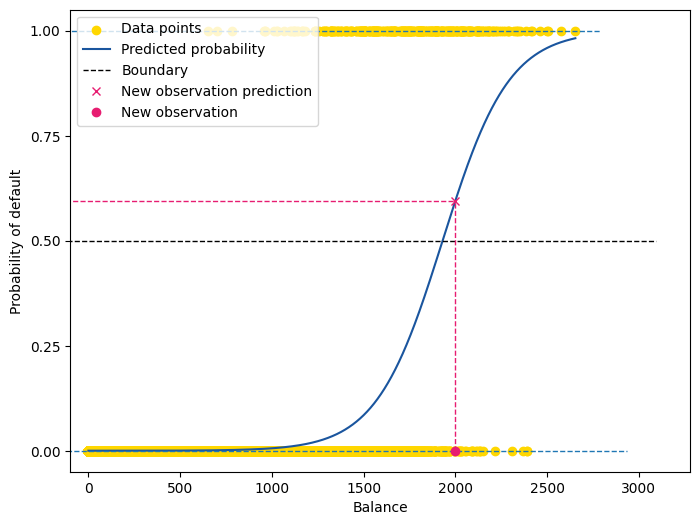

In [60]:
# Plot the graph
plt.figure(figsize=(8, 6))

# Scatter plot and line plot
plt.scatter(x, y, color='gold', label='Data points')
plt.plot(X_space, prob[:, 1], color=color_blue, label='Predicted probability')

# Add horizontal lines upper bound
plt.hlines(1, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines lower bound
plt.hlines(0, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines, the discriminant boundary
plt.hlines(0.5, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1, colors='black', label='Boundary')
# Add new observation
plt.vlines(new_balance_obs, ymin=0, ymax=prob_new_obs, linestyles='dashed', lw=1, colors=color_pink)
plt.hlines(prob_new_obs, xmin=plt.gca().get_xlim()[0], xmax=new_balance_obs, linestyles='dashed', lw=1, colors=color_pink)
plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction', color=color_pink)
plt.plot(new_balance_obs, 0, 'go', label='New observation', color=color_pink)


# Set labels and ticks
plt.ylabel('Probability of default')
plt.xlabel('Balance')
plt.yticks([0, 0.25, 0.5, 0.75, 1.])
plt.xlim(xmin=-100)

# Add legend
plt.legend(loc='upper left')

# Show plot
plt.show()

In [61]:
# Look at the parameters
print('classes: ',logistic.classes_)
print('coefficients: ',logistic.coef_)
print('intercept :', logistic.intercept_)

classes:  [0 1]
coefficients:  [[0.00553357]]
intercept : [-10.68173157]


In [62]:
# statsmodels needs the intercept to be included in the X_train
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train, columns=['balance']))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2()# .tables[1]

Optimization terminated successfully.
         Current function value: 0.079083
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.458      
Date:               2025-02-26 22:42 AIC:              1269.3267  
No. Observations:   8000             BIC:              1283.3011  
Df Model:           1                Log-Likelihood:   -632.66    
Df Residuals:       7998             LL-Null:          -1166.9    
Converged:          1.0000           LLR p-value:      2.3216e-234
No. Iterations:     10.0000          Scale:            1.0000     
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
const       -10.6817    0.4052  -26.3632  0.0000  -11.4759  -9.8876
balance       0.0055    0.0002   22.3104  0.0000    0.0050   0.0060
==================================================================

"""

# Multiple Logistic Regression

In [31]:
X = df[['balance', 'income', 'student_enc']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary().tables[1]

# Confusion Matrix

In [ ]:
# Add an intercept to the test dataset
X_test_w_intercept = sm.add_constant(X_test)

# Predict probabilities using the trained model
pred = est.predict(X_test_w_intercept).round(2)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (pred > 0.5).astype(int)

# Print only the first 20 pairs with formatted alignment
print(f"{'Pred Prob':<12} {'Pred Class':<12}")  # Header
print("-" * 25)

for i in range(270, 290):
    print(f"{pred.values[i]:<12} {y_pred.values[i]:<12}")





In [ ]:
print(y_pred.value_counts())

In [ ]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title('Confusion Matrix')
plt.show()

In [36]:
# Function to evaluate the performance of a classification model
def evaluate_classification_performance(y_test, y_pred):
    """
    Evaluate and print out standard classification metrics.
    """
    # Compute the confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate specificity = TN / (TN + FP)
    specificity = tn / (tn + fp)
    
    # Calculate other metrics using scikit-learn
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    # FPR = 1 - specificity
    fpr = 1 - specificity
    
    # Print all metrics in a neat format
    print(f"Accuracy:    {accuracy:.2f}")
    print(f"Precision:   {precision:.2f}")
    print(f"Recall:      {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"FPR:         {fpr:.2f}")
    print(f"F1 Score:    {f1:.2f}")
    
    # Optionally return metrics in a dictionary if needed
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'fpr': fpr,
        'f1_score': f1
    }

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Calculate accuracy
metrics_dict = evaluate_classification_performance(y_test, y_pred)


In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUC
roc_auc = roc_auc_score(y_test, pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='gold', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=color_blue, lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Calculate the Gini coefficient
gini = 2 * roc_auc - 1
print('Gini coefficient: %.2f' % gini)

In [79]:
from imblearn.over_sampling import SMOTE

# Impostiamo il moltiplicatore per l'oversampling
oversampling_ratio = 1.2

# Separiamo le classi
df_minority = df[df['default_enc'] == 1][['balance', 'default_enc']]  # Classe minoritaria
df_majority = df[df['default_enc'] == 0][['balance', 'default_enc']]  # Classe sovrarappresentata

# Determiniamo il numero di campioni da mantenere dalla classe dominante
n_minority = len(df_minority)
n_majority_selected = int(n_minority * oversampling_ratio)

# Selezioniamo casualmente un sottoinsieme della classe dominante
df_majority_selected = df_majority.sample(n=n_majority_selected, random_state=42)

# Concatenazione delle due classi per formare il dataset bilanciato
df_balanced = pd.concat([df_minority, df_majority_selected])

# Applichiamo SMOTE solo sulla parte bilanciata
X_balanced = df_balanced.drop(columns=['default_enc'])
y_balanced = df_balanced['default_enc']

In [ ]:
df_majority_selected

,default,student,balance,income,default_enc,student_enc
Index,,,,,,
5378,No,No,702.159263,57468.404441,0,0
2480,No,No,1709.344285,35290.523111,0,0
7801,No,No,995.346100,46702.239073,0,0
2365,No,No,1546.760526,32928.636126,0,0
4426,No,No,145.476590,41196.420202,0,0
...,...,...,...,...,...,...
6841,No,No,341.386840,29326.339236,0,0
7771,No,Yes,686.694379,18551.530058,0,1
7010,No,No,1393.369463,43439.674070,0,0


C:\Users\vinor\AppData\Local\Temp\ipykernel_37800\2704435100.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_synthetic['synthetic'] = True


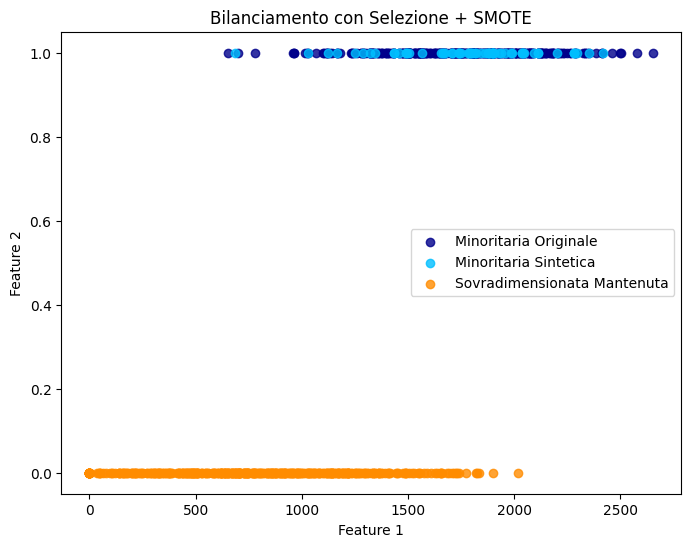

In [80]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_balanced, y_balanced)

# Creiamo un nuovo dataframe per mantenere traccia delle aggiunte
df_resampled = pd.DataFrame(X_resampled, columns=X_balanced.columns)
df_resampled['default_enc'] = y_resampled

# Identifichiamo le osservazioni sintetiche create
df_synthetic = df_resampled.iloc[len(df_balanced):]  # SMOTE aggiunge alla fine
df_synthetic['synthetic'] = True

# Aggiungiamo la colonna per indicare osservazioni originali nel dataset
df_balanced['synthetic'] = False

# Concateniamo il dataset originale bilanciato con le osservazioni sintetiche
df_final = pd.concat([df_balanced, df_synthetic])

# Visualizziamo il risultato
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Classe minoritaria originale - blu scuro
plt.scatter(df_minority.iloc[:, 0], df_minority.iloc[:, 1], c='darkblue', label="Minoritaria Originale", alpha=0.8)

# Classe minoritaria sintetica - blu chiaro
plt.scatter(df_synthetic.iloc[:, 0], df_synthetic.iloc[:, 1], c='deepskyblue', label="Minoritaria Sintetica", alpha=0.8)

# Classe sovradimensionata mantenuta - arancione
plt.scatter(df_majority_selected.iloc[:, 0], df_majority_selected.iloc[:, 1], c='darkorange', label="Sovradimensionata Mantenuta", alpha=0.8)

plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Bilanciamento con Selezione + SMOTE")
plt.show()


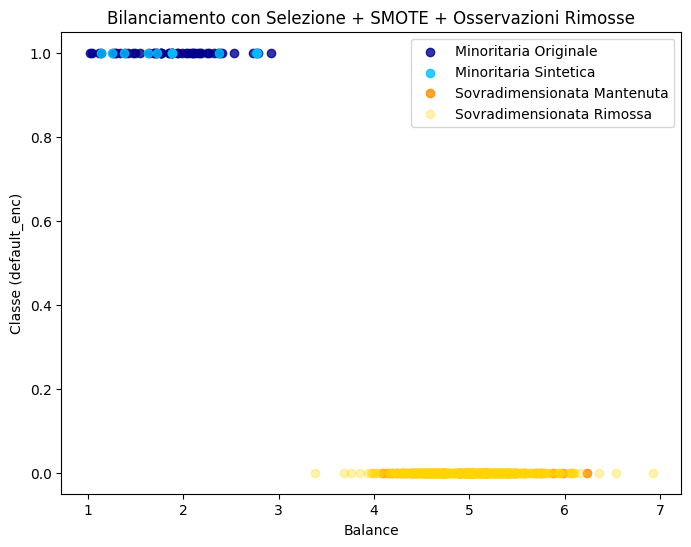

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Simuliamo un dataset sbilanciato per il test
np.random.seed(42)
n_minority = 50  # Classe minoritaria
n_majority = 500  # Classe sovradimensionata

# Creazione dati sintetici
X_minority = np.random.normal(loc=[2], scale=[0.5], size=(n_minority, 1))
X_majority = np.random.normal(loc=[5], scale=[0.5], size=(n_majority, 1))

# Creazione target
y_minority = np.ones(n_minority)  # Classe minoritaria (1)
y_majority = np.zeros(n_majority)  # Classe maggioritaria (0)

# Unione in un dataframe
df = pd.DataFrame(np.vstack((X_minority, X_majority)), columns=['balance'])
df['default_enc'] = np.hstack((y_minority, y_majority))

# Impostiamo il moltiplicatore per l'oversampling
oversampling_ratio = 1.2

# Separiamo le classi
df_minority = df[df['default_enc'] == 1][['balance', 'default_enc']]  # Classe minoritaria
df_majority = df[df['default_enc'] == 0][['balance', 'default_enc']]  # Classe sovrarappresentata

# Determiniamo il numero di campioni da mantenere dalla classe dominante
n_minority = len(df_minority)
n_majority_selected = int(n_minority * oversampling_ratio)

# Selezioniamo casualmente un sottoinsieme della classe dominante
df_majority_selected = df_majority.sample(n=n_majority_selected, random_state=42)

# Identifichiamo le osservazioni rimosse
df_majority_removed = df_majority.drop(df_majority_selected.index)

# Concatenazione delle due classi per formare il dataset bilanciato
df_balanced = pd.concat([df_minority, df_majority_selected])

# Applichiamo SMOTE solo sulla parte bilanciata
X_balanced = df_balanced.drop(columns=['default_enc'])
y_balanced = df_balanced['default_enc']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_balanced, y_balanced)

# Creiamo un nuovo dataframe per mantenere traccia delle aggiunte
df_resampled = pd.DataFrame(X_resampled, columns=X_balanced.columns)
df_resampled['default_enc'] = y_resampled

# Identifichiamo le osservazioni sintetiche create
df_synthetic = df_resampled.iloc[len(df_balanced):].copy()  # SMOTE aggiunge alla fine
df_synthetic['synthetic'] = True

# Aggiungiamo la colonna per indicare osservazioni originali nel dataset
df_balanced['synthetic'] = False

# Concateniamo il dataset originale bilanciato con le osservazioni sintetiche
df_final = pd.concat([df_balanced, df_synthetic])

# **Visualizzazione del risultato**
plt.figure(figsize=(8, 6))

# Classe minoritaria originale - blu scuro
plt.scatter(df_minority['balance'], df_minority['default_enc'], c='darkblue', label="Minoritaria Originale", alpha=0.8)

# Classe minoritaria sintetica - blu chiaro
plt.scatter(df_synthetic['balance'], df_synthetic['default_enc'], c='deepskyblue', label="Minoritaria Sintetica", alpha=0.8)

# Classe sovradimensionata mantenuta - arancione
plt.scatter(df_majority_selected['balance'], df_majority_selected['default_enc'], c='darkorange', label="Sovradimensionata Mantenuta", alpha=0.8)

# Classe sovradimensionata rimossa - arancione con alpha alto
plt.scatter(df_majority_removed['balance'], df_majority_removed['default_enc'], c='gold', label="Sovradimensionata Rimossa", alpha=0.3)

plt.legend()
plt.xlabel("Balance")
plt.ylabel("Classe (default_enc)")
plt.title("Bilanciamento con Selezione + SMOTE + Osservazioni Rimosse")
plt.show()
